# 2D Aircraft Dynamics for Maneuvers

Let's look at a similar problem, but perhaps with some more exciting dynamics.

Suppose we have an [adrenaline-loving wingsuit pilot](https://en.wikipedia.org/wiki/Wingsuit_flying) who wants to race her friend to the bottom of a mountain.

Let's make some procedurally-generated mountain as follows:

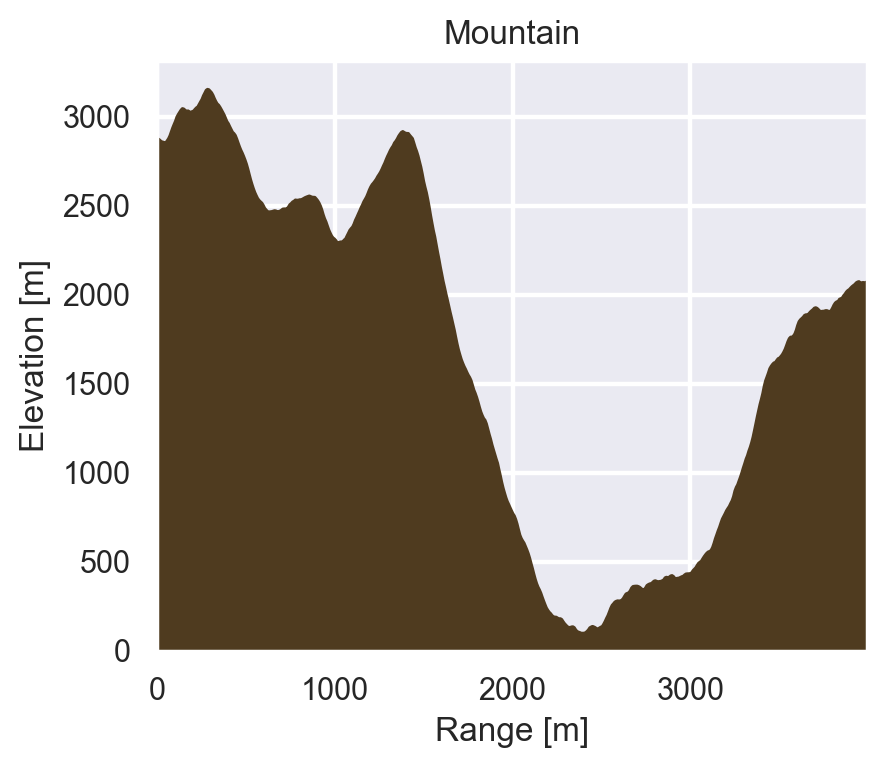

In [77]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt;
import aerosandbox.tools.pretty_plots as p

np.random.seed(5)


class Mountain:
    color = "#4f3b1f"

    def __init__(self,
                 x_max=4000,
                 resolution=8,  # Note - log-scaled
                 ):
        k = np.arange(2 ** resolution)
        d_omega = 2 * np.pi / len(k)
        omega = d_omega * np.arange(len(k))

        spatial_power = (omega + 1e-16) ** -3.5
        spatial_power[0] = 0  # Zero the DC-mode power

        spatial_amps = np.sqrt(2 * spatial_power * d_omega)
        spatial_phase = np.random.random(spatial_power.shape) * 2 * np.pi
        spatial_freq_signal = spatial_amps * np.exp(1j * spatial_phase)
        elevation = np.fft.irfft(
            spatial_freq_signal, axis=0
        )
        x = x_max * np.arange(len(elevation)) / len(elevation)

        elevation *= 2000
        elevation += - 0.2 * x
        # elevation += np.where(
        #     x > 3000,
        #     500 * ((x-3000) / 1000) ** 2,
        #     0
        # )
        from scipy import stats
        elevation += stats.norm(1400, 100).pdf(x) * 1.1e5
        elevation += 100 - elevation.min()

        self.x_data = x
        self.elevation_data = elevation

    def elevation(self, x):
        return np.interp(
            x=x,
            xp=self.x_data,
            fp=self.elevation_data
        )

    def draw(self,
             show=True,
             set_bounds=True,
             set_equal=True,
             ):
        plt.fill_between(
            self.x_data,
            0,
            self.elevation_data,
            color=self.color
        )
        if set_equal:
            plt.gca().set_aspect("equal", adjustable='box')
        if set_bounds:
            plt.xlim(
                self.x_data.min(),
                self.x_data.max()
            )
            plt.ylim(bottom=0)
        if show:
            plt.show()


mountain = Mountain()
mountain.draw(show=False)
p.show_plot("Mountain", "Range [m]", "Elevation [m]")


Let's start our wingsuit pilot at the top of that peak there.

In [78]:
x_peak = mountain.x_data[np.argmax(mountain.elevation_data)]
elevation_peak = np.max(mountain.elevation_data)

And, let's see how fast we can get to the bottom of this mountain!

In [79]:
### Initialize the problem
opti = asb.Opti()

### Define time. Note that the horizon length is unknown.
# time_final_guess = 100
# time = np.linspace(
#     0,
#     opti.variable(init_guess=time_final_guess, log_transform=True),
#     250
# )
time = opti.variable(init_guess=np.linspace(0, 100, 150))
opti.subject_to([
    time[0] == 0,
    np.diff(time) > 0,
])
N = np.length(time)

### Create a dynamics instance

dyn = asb.DynamicsPointMass2DSpeedGamma(
    mass_props=asb.MassProperties(mass=80),
    x_e=np.linspace(x_peak, mountain.x_data.max(), N),
    z_e=opti.variable(np.linspace(-elevation_peak, -mountain.elevation_data[-1], N)),
    speed=opti.variable(init_guess=50, n_vars=N),
    gamma=opti.variable(init_guess=0, n_vars=N, lower_bound=-np.pi / 2, upper_bound=np.pi / 2),
    alpha=opti.variable(init_guess=5, n_vars=N, lower_bound=-5, upper_bound=15),
)
# Constrain the initial state
opti.subject_to([
    dyn.z_e[0] == -elevation_peak,
    dyn.speed[0] == 50,
    dyn.gamma[0] == np.pi / 2
])

### Add in forces
dyn.add_gravity_force(g=9.81)

### Add in custom lift and drag
S = 1
CL = 2 * np.pi * np.sind(dyn.alpha)
CD = 2 * np.sind(dyn.alpha) ** 2 + 0.1

lift = dyn.op_point.dynamic_pressure() * CL * S
drag = dyn.op_point.dynamic_pressure() * CD * S

dyn.add_force(
    Fx=-drag,
    Fz=-lift,
    axes="wind"
)

### Constrain the altitude to be above ground at all times
opti.subject_to([
    dyn.altitude > mountain.elevation(dyn.x_e)
    # dyn.altitude[-1] == 0,
])

### Finalize the problem
dyn.constrain_derivatives(opti, time)  # Apply the dynamics constraints created up to this point

opti.minimize(time[-1])  # Go as far downrange as you can

### Solve it
sol = opti.solve(verbose=False)

### Substitute the optimization variables in the dynamics instance with their solved values (in-place)
dyn.substitute_solution(sol)

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


DynamicsPointMass2DSpeedGamma instance:
	State variables:
		     x_e: [ 282.35294118  307.25095407  332.148...
		     z_e: [-3158.33762115 -3257.01774862 -3267....
		   speed: [50.         22.12728141 17.01697833 ...
		   gamma: [ 1.57079633  0.73791245 -0.02478609 ...
	Control variables:
		   alpha: [-5.00000005 -5.00000005 -5.00000005 ...
		    Fx_w: [-9.13309232e+02 -5.52882525e+02  4.7...
		    Fz_w: [ 610.92366995  699.08516124  854.525...

Let's draw the solution:

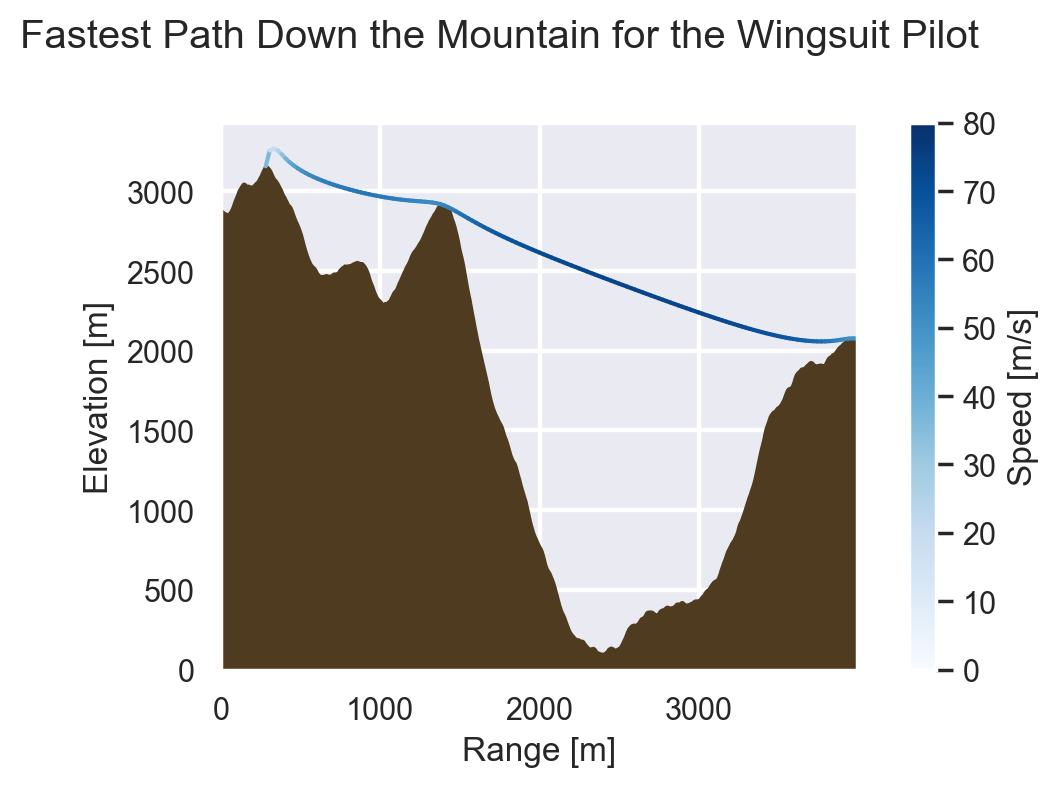

In [91]:
# plt.plot(dyn.x_e, dyn.altitude)
p.plot_color_by_value(
    dyn.x_e,dyn.altitude,
    c=dyn.speed,
    colorbar=True,
    cmap="Blues",
    clim=(0,80),
    colorbar_label="Speed [m/s]"
)
mountain.draw(show=False)
p.show_plot(
    "Fastest Path Down the Mountain for the Wingsuit Pilot",
    "Range [m]",
    "Elevation [m]",
)

And, our wingsuit pilot can descend from the mountain in:

In [92]:
print(f"{sol.value(time[-1]):.2f} seconds")

68.73 seconds
